# Examples of usage

In [1]:
import rna
from BasePredictor import BasePredictor
from NaivePredictor import NaivePredictor
from GeneticPredictor import GeneticPredictor
from MFTPredictor import MFTPredictor

%matplotlib inline

Using gpu device 0: GeForce GTX 970M (CNMeM is disabled, cuDNN not available)


### Data
Examples are loaded from a file in FASTA-like format (see secondary.fa as an example). If you don't want to load RNA sequences with provided method, you can insert your data directly to predictor's **train** method. Such data should be a numpy array, and its dimensions should be $(n \times 2)$, wherein the first column contains RNA sequences, and the second column contains bracket notations that describe the secondary structure.

### Naïve Predictor
This predictor is a simple MLP. It looks for the most similar RNA sequence in training data and applies the same structure to predicted sequence. The performance of such a predictor is not very good, but it can be quite accurate when there exists a homologous RNA sequence in training examples. One can use Genetic Predictor afterwards, to improve the result.

In [4]:
p = NaivePredictor(22, substrings=False, max_examples=100, library='lasagne', data_model='matrix')
X = p.load_data("secondary.fa", capitalize=True, purify=True, repair=True)
print("Shape of the data:")
print(X.shape)

print("\nA few of loaded examples:")
print(X[:10])

Shape of the data:
(939, 2)

A few of loaded examples:
[['GGCGUAAGGAUUACCUAUGCC' '(((((..((....)).)))))']
 ['GGACUAGCGGAGGCUAGUCC' '(((..(((....)))..)))']
 ['GCGCUGACAAAGCGC' '(((((.....)))))']
 ['GGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGCC'
  '((((.......(((((((.....))))))).......))))']
 ['GGGAGCUCAACUCUCCCCCCCUUUUCCGAGGGUCAUCGGAACCA'
  '(((((.......))))).......(((((......)))))....']
 ['GGGUGACUCCAGAGGUCGAGAGACCGGAGAUAUCACCC'
  '((((((((((...((((....))))))))...))))))']
 ['GGUGUGAACACC' '((((....))))']
 ['GACAGGGGAAACUUUGUC' '(((((((....)))))))']
 ['GCCAGAUUGAGCCUGGGAGCUCUCUGGCC' '((((((..((((......)))))))))).']
 ['GGCCAGAUUGAGCCUGGGAGCUCUCUGGCC' '(((((((..((((......)))))))))))']]


### Molecule class
You can store RNA sequences as an instance of Molecule class. It provides tools for the structure visualization.

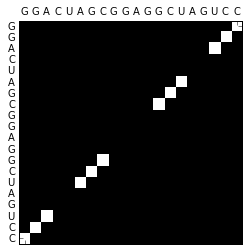

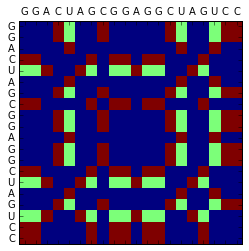

In [8]:
m = rna.Molecule(X[1, 0], X[1, 1])
rna.pair_matrix(m, show=True)
rna.complementarity_matrix(m, show=True)
m.show()

![RNA](rna.png)

In [12]:
p.train()
print("We will be trying to predict the secondary structure of the following sequence: GGCCUGAGGAGACUCAGAAGCC.\n")
print(p.predict("GGCCUGAGGAGACUCAGAAGCC"))
print("\nThis is the correct structure. Next tests check if our predictor can cope with slightly different sequences (reverse sequence or changed basepairs).\n")
print(p.predict("GGCCUGAGGAGACUCAGAAGCC"[::-1]))
print(p.predict("CCCCUGAGGAGACUCAGAAGGG"))
print(p.predict("AUCCUGAGGAGACUCAGAAGAU"))
print(p.predict("AUCGUGAUGAGACUCAAAAGAU"))

We will be trying to predict the secondary structure of the following sequence: GGCCUGAGGAGACUCAGAAGCC.

0.994215 0.363563
GGCCUGAGGAGACUCAGAAGCC
(((((((......))))..)))

This is the correct structure. Next tests check if our predictor can cope with slightly different sequences (reverse sequence or changed basepairs).

0.929067 0.999614
CCGAAGACUCAGAGGAGUCCGG
(((..((((......)))))))
0.554652 0.453151
CCCCUGAGGAGACUCAGAAGGG
(((((((......))))..)))
0.868492 0.443768
AUCCUGAGGAGACUCAGAAGAU
(((((((......))))..)))
0.694795 0.792209
AUCGUGAUGAGACUCAAAAGAU
(((((((((....)))))))))


### Genetic Predictor
As we see, sometimes finding the most similar structure is not enough. We should find a way to improve our results, so let us try a different approach to the problem. A simple genetic algorithm can repair sequences with incorrect basepairs and sharp loops. Then it makes random connections and evaluates the new structure.

Let's look at the last prediction of our Naive Predictor. Obviously, it is not the correct structure. We can try to improve the result with a Genetic Predictor.

In [23]:
p = GeneticPredictor(num_epoch=20)
p.predict(rna.Molecule("AUCGUGAUGAGACUCAAAAGAU", "(((((((((....)))))))))"))

[
 AUCGUGAUGAGACUCAAAAGAU
 (((.(((......)))...))), 
 AUCGUGAUGAGACUCAAAAGAU
 (((.(((......))..).))), 
 AUCGUGAUGAGACUCAAAAGAU
 (((.(..((.....))..)))), 
 AUCGUGAUGAGACUCAAAAGAU
 (((.(((......)).)..))), 
 AUCGUGAUGAGACUCAAAAGAU
 (((.(..((.....)).).)))]

One of the structures of the last population looks better than others:
![rna2](rna2.png)
It is indeed one of the most probable structures according to other predictors that you can find online, e.g. [this web server](http://rna.urmc.rochester.edu/RNAstructureWeb/Servers/Predict1/Predict1.html).

The last example will show that Genetic Predictor can make predictions from scratch. It makes it competitive with other more complex predictors. Its decision process is almost completely random, and it may converge to local minima, but it has very simple implementation, which makes it faster than other predictors. Let's try to predict the same sequence the Naive Predictor has earlier predicted correctly.

In [30]:
predictions = []

# we use the predictor 10 times and choose the best result to avoid locality
for test in range(10):
    predictions += p.predict(rna.Molecule("GGCCUGAGGAGACUCAGAAGCC"))

print(sorted(predictions, key=lambda x: x.evaluate())[-3:])

[
GGCCUGAGGAGACUCAGAAGCC
((((((((....)))))..)))
, 
GGCCUGAGGAGACUCAGAAGCC
((((((((....)))))..)))
, 
GGCCUGAGGAGACUCAGAAGCC
((((((((....)))))..)))
]


The prediction is correct.

### MFT Predictor
MFT Predictor is based on [this article](http://aitopics.org/sites/default/files/classic/Hunter/03-Steeg.pdf) (Steeg). The network works similarly to Hopfield networks. However, neurons can have activation level equal to any number $a_i \in [0, 1]$, and not only binary. The activation function is given by the formula:

\begin{equation}
a_i = \sum_j a_j w_{ij} + f(i),
\end{equation}
where
- $a_i$ - activation of $i$-th neuron,
- $w_{ij}$ - edge weight between neurons $i$ and $j$,
- $f(i)$ - node weight for neuron's basepair.

In [31]:
p = MFTPredictor(num_epoch=100, alpha=6, beta=8, gamma=30, temperature=1/5)
predictions = []
for i in range(10):
    print(p.predict(rna.Molecule("GGCCUGAGGAGACUCAGAAGCC")))

GGCCUGAGGAGACUCAGAAGCC
(((.(..(((..)))..).)))
GGCCUGAGGAGACUCAGAAGCC
(((.(...((...))..).)))
GGCCUGAGGAGACUCAGAAGCC
((.((....))...).....).
GGCCUGAGGAGACUCAGAAGCC
(((.(.....(...)...))))
GGCCUGAGGAGACUCAGAAGCC
((((((((....)))))..)))
GGCCUGAGGAGACUCAGAAGCC
(......(....((...).)))
GGCCUGAGGAGACUCAGAAGCC
((.((....)).).).(...).
GGCCUGAGGAGACUCAGAAGCC
(((.(...((...))..).)))
GGCCUGAGGAGACUCAGAAGCC
(.(....)(...(...)...))
GGCCUGAGGAGACUCAGAAGCC
((((((((....)))))..)))


It seems that this predictor can produce good predictions, but it is dependent on many parameters that can be learnt from data. However, the training method is not well implemented yet.